<a href="https://colab.research.google.com/github/hartonosng/mygithub/blob/master/VDSR_ANIDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
#Pakai GPU
import tensorflow as tf
tf.test.gpu_device_name()

#Listing device
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

#Checking RAM
!cat /proc/meminfo

MemTotal:       13302928 kB
MemFree:        10218072 kB
MemAvailable:   12267456 kB
Buffers:           83224 kB
Cached:          2088924 kB
SwapCached:            0 kB
Active:          1185556 kB
Inactive:        1631024 kB
Active(anon):     598524 kB
Inactive(anon):      456 kB
Active(file):     587032 kB
Inactive(file):  1630568 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1276 kB
Writeback:             0 kB
AnonPages:        644372 kB
Mapped:           429440 kB
Shmem:              1160 kB
KReclaimable:     146516 kB
Slab:             197428 kB
SReclaimable:     146516 kB
SUnreclaim:        50912 kB
KernelStack:        5600 kB
PageTables:        26048 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651464 kB
Committed_AS:    9488276 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        8120 kB
VmallocChunk:          0 kB
Percpu:          

In [15]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

In [16]:
import glob

# Importing drive method from colab for accessing google drive
from google.colab import drive

In [17]:
# Mounting drive
# This will require authentication : Follow the steps as guided
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
# Viewing the data in the folder present from the drive
!ls "/content/gdrive/My Drive/train/"

100075.jpg  135.jpg	172.jpg     216081.jpg	33.jpg	    60.jpg
100080.jpg  136.jpg	173036.jpg  219090.jpg	3421.jpg    61060.jpg
100098.jpg  137.jpg	173.jpg     220075.jpg	34.jpg	    61086.jpg
100.jpg     138032.jpg	174.jpg     22013.jpg	35008.jpg   61.jpg
101087.jpg  138078.jpg	175032.jpg  22090.jpg	35010.jpg   62.jpg
101.jpg     138.jpg	175043.jpg  22093.jpg	35058.jpg   63.jpg
102.jpg     139.jpg	175.jpg     223061.jpg	35070.jpg   64.jpg
103041.jpg  13.jpg	176019.jpg  225017.jpg	35091.jpg   65010.jpg
103070.jpg  140055.jpg	176035.jpg  227040.jpg	3521.jpg    65019.jpg
103.jpg     140075.jpg	176039.jpg  227046.jpg	353013.jpg  65074.jpg
104022.jpg  140.jpg	176.jpg     227092.jpg	35.jpg	    65132.jpg
104.jpg     141.jpg	177.jpg     229036.jpg	361084.jpg  65.jpg
105019.jpg  142.jpg	178054.jpg  23025.jpg	365025.jpg  66039.jpg
105053.jpg  143090.jpg	178.jpg     23080.jpg	365073.jpg  66075.jpg
105.jpg     143.jpg	179.jpg     23084.jpg	368016.jpg  66.jpg
106020.jpg  144067.jpg	180.jpg     231015

In [20]:
face_images = glob.glob ('/content/gdrive/My Drive/train/*.jpg') #gives path

print(face_images[:10], len(face_images))

['/content/gdrive/My Drive/train/41004.jpg', '/content/gdrive/My Drive/train/365025.jpg', '/content/gdrive/My Drive/train/187029.jpg', '/content/gdrive/My Drive/train/46076.jpg', '/content/gdrive/My Drive/train/56028.jpg', '/content/gdrive/My Drive/train/66075.jpg', '/content/gdrive/My Drive/train/370036.jpg', '/content/gdrive/My Drive/train/361084.jpg', '/content/gdrive/My Drive/train/100075.jpg', '/content/gdrive/My Drive/train/20008.jpg'] 450


In [21]:
with open('face_images_path.pickle','wb') as f: 
  pickle.dump (face_images,f) 

In [22]:
from tqdm import tqdm         #A progess library
from multiprocessing import Pool
progress = tqdm(total= len(face_images), position=0)  

print(progress)
def read(path):
  img = image.load_img(path, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

#p = Pool(1)
p = Pool(10) #awalnya ini
img_array = p.map(read, face_images)

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]


 11%|█         | 48/450 [00:24<03:40,  1.82it/s]

In [23]:
ls

face_images_path.pickle  gdrive/  img_array.pickle  sample_data/


In [24]:
with open('img_array.pickle','wb') as f:
  pickle.dump(img_array, f)

In [25]:
len(img_array)

450

In [26]:
with open('img_array.pickle','rb') as f:
  img_array = pickle.load(f)

In [27]:
ls

face_images_path.pickle  gdrive/  img_array.pickle  sample_data/


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


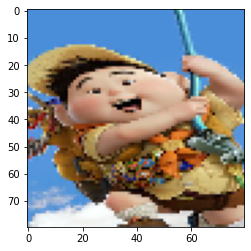

In [29]:
plt.imshow(img_array[449])

In [30]:
all_images = np.array(img_array)

In [31]:
#print(all_images)
all_images.shape

(450, 80, 80, 3)

In [32]:
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [33]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [34]:
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [35]:
train_x_px.shape

(360, 80, 80, 3)

In [36]:
val_x_px.shape

(90, 80, 80, 3)

In [37]:
ls

ls: cannot access 'gdrive': Transport endpoint is not connected
drive/  face_images_path.pickle  gdrive/  img_array.pickle  sample_data/


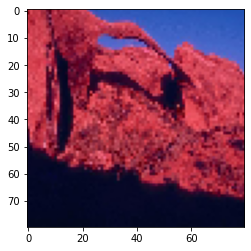

In [38]:
plt.imshow(train_x[99])

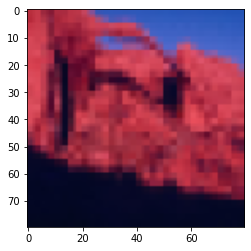

In [39]:
plt.imshow(train_x_px[99])

In [44]:
# VDSR original
Input_img = Input(shape=(80, 80, 3))  

x1 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x2)
x4 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x5)
x7 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
x8 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x9)
x11 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x10)
x12 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x13)
x15 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x14)
x16 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x15)
x17 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x16)
x18 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x17)
x19 = Conv2D(12, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x18)
x20 = Conv2D(1, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x19)
x21 = Add()([x1, x20])

vdsr_model = Model(Input_img, x21)
vdsr_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
vdsr_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 80, 80, 12)   336         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 80, 80, 12)   1308        conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 80, 80, 12)   1308        conv2d_41[0][0]                  
____________________________________________________________________________________________

In [47]:
train_x_px.shape

(360, 80, 80, 3)

In [51]:
train_x.shape

(360, 80, 80, 3)

In [52]:
val_x_px.shape

(90, 80, 80, 3)

In [55]:
val_x.shape

(90, 80, 80, 3)

In [58]:
model_checkpoint

In [59]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
# model_checkpoint = ModelCheckpoint('vdsr-tes.h5',save_best_only=True)
# abcd = vdsr_model.fit(train_x_px,train_x, epochs=200, validation_data=(val_x_px, val_x), callbacks=[early_stopper, model_checkpoint])
vdsr_model = tf.keras.models.load_model('vdsr-tes.h5')
vdsr_model.fit(train_x_px,train_x, epochs=200, validation_data=(val_x_px, val_x), callbacks=[early_stopper])
predictions = vdsr_model.predict(val_x_px)

n = 4
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  ax.set_title("Distorted (Low Resolution) Image")
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  ax.set_title("Predicted Image")
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

OSError: ignored

In [ ]:
results = vdsr_model.evaluate(val_x_px, val_x)
print('loss, accuracy', results)

ValueError: ignored

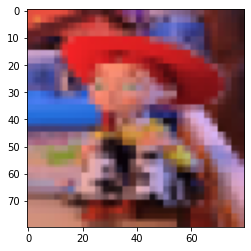

In [ ]:
img = image.load_img('/content/gdrive/My Drive/train/train/11.jpg', target_size=(80,80,3))
img = image.img_to_array(img)
img = img/255.
img = pixalate_image(img)
plt.imshow(img)
# di save jadi download1.png

TypeError: ignored

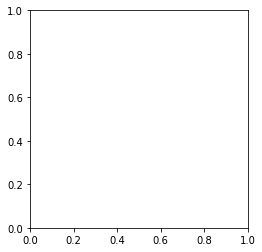

In [ ]:
input_array = np.array([img])
#print(input_array)
predict = vdsr_model.predict(input_array)
#print(predict)
plt.imshow(predict[0])
# di save jadi download2.png

In [ ]:
import math
from sklearn.metrics import mean_squared_error
from math import sqrt

diff = input_array - predict
mse = np.mean((diff) ** 2)
psnr = 20 * math.log10(255.0 / math.sqrt(mse))
rmse = math.sqrt(np.mean(diff ** 2.))
#psnr = 20 * math.log10(255. / rmse)

print('mse=')
print(mse)

print('rmse=')
print(rmse)

print('psnr=')
print(psnr)

ValueError: ignored